In [1]:
import os
import re
import glob
import copy
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.dataset import IDC_Dataset, load_dataset, create_transforms
from utils.models import SimpleNeuralNet, SimpleConvNet, ConvNet, LargeConvNet

In [2]:
# Desactivem un warning de pytorch que podem ignorar (https://github.com/pytorch/pytorch/issues/97207)
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        message='TypedStorage is deprecated')


In [3]:
# Carreguem el dataset a partir del path on es troben les imatges
base_path = "./dataset/IDC_regular_ps50_idx5"
images, labels, metadata = load_dataset(base_path)

# Calcular mitjana i desviació estàndard per a normalitzar les imatges
mean = np.mean(images, axis=(0, 1, 2)) / 255
std = np.std(images, axis=(0, 1, 2)) / 255

data_transforms = create_transforms(mean, std)


Carregant imatges IDC-positives...: 100%|██████████| 78224/78224 [00:27<00:00, 2847.07it/s]


In [4]:
def train_loop(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels, _ in tqdm(train_loader, desc=f"TRAINING EPOCH {epoch + 1}/{num_epochs}", unit=" batches"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total_samples += len(labels)

        train_losses.append(running_loss / total_samples)
        train_accuracies.append(running_corrects.item() / total_samples)

        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_loop(
            model, val_loader, criterion, device)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

    return train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores


def evaluate_loop(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total_samples += len(labels)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return (running_loss / total_samples,
            running_corrects.item() / total_samples,
            precision,
            recall,
            f1)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models = {
    "SimpleNeuralNet": SimpleNeuralNet(50 * 50 * 3).to(device),
    "SimpleConvNet": SimpleConvNet().to(device),
    "ConvNet": ConvNet().to(device),
    "LargeConvNet": LargeConvNet().to(device),
}

k_folds = 5
num_epochs = 20
batch_size = 32
learning_rate = 0.0001

# Guardem un "historial" de les mètriques de cada model
all_train_losses = {name: [] for name in models.keys()}
all_train_accuracies = {name: [] for name in models.keys()}

all_val_accuracies = {name: [] for name in models.keys()}
all_val_losses = {name: [] for name in models.keys()}
all_val_precisions = {name: [] for name in models.keys()}
all_val_recalls = {name: [] for name in models.keys()}
all_val_f1_scores = {name: [] for name in models.keys()}

gkf = GroupKFold(n_splits=k_folds)

for model_name, model in models.items():
    print(f"Entrenant model {model_name}...")
    for train_idx, val_idx in gkf.split(images, labels, [md[0] for md in metadata]):
        train_set = IDC_Dataset(
            images[train_idx], labels[train_idx], metadata[train_idx], transform=data_transforms)
        val_set = IDC_Dataset(
            images[val_idx], labels[val_idx], metadata[val_idx], transform=data_transforms)

        train_loader = DataLoader(
            train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(
            val_set, batch_size=batch_size, shuffle=False)

        model_instance = copy.deepcopy(model).to(device)
        optimizer = torch.optim.AdamW(
            model_instance.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores = train_loop(
        model_instance, train_loader, val_loader, optimizer, criterion, num_epochs, device
    )

        all_train_losses[model_name].append(train_losses)
        all_train_accuracies[model_name].append(train_accuracies)
        all_val_losses[model_name].append(val_losses)
        all_val_accuracies[model_name].append(val_accuracies)
        all_val_precisions[model_name].append(val_precisions)
        all_val_recalls[model_name].append(val_recalls)
        all_val_f1_scores[model_name].append(val_f1_scores)


Entrenant model SimpleNeuralNet...


TRAINING EPOCH 20/20: 100%|██████████| 6811/6811 [00:48<00:00, 139.89 batches/s]


Entrenant model SimpleConvNet...


TRAINING EPOCH 20/20: 100%|██████████| 6811/6811 [00:48<00:00, 139.53 batches/s]


Entrenant model ConvNet...


TRAINING EPOCH 20/20: 100%|██████████| 6811/6811 [00:51<00:00, 132.99 batches/s]


Entrenant model LargeConvNet...


TRAINING EPOCH 20/20: 100%|██████████| 6811/6811 [00:54<00:00, 123.84 batches/s]


In [5]:
def print_model_metrics(models, all_val_losses, all_val_accs, all_val_precisions, all_val_recalls, all_val_f1_scores):
    print("Model Performance Metrics:")
    print("----------------------------------------------------------------------------------")
    for model_name in models.keys():
        print(f"Model: {model_name}")
        print(f"Average Validation Loss: {np.mean(all_val_losses[model_name]):.4f}")
        print(f"Average Validation Accuracy: {np.mean(all_val_accs[model_name]) * 100:.2f}%")
        print(f"Average Validation Precision: {np.mean(all_val_precisions[model_name]) * 100:.2f}%")
        print(f"Average Validation Recall: {np.mean(all_val_recalls[model_name]) * 100:.2f}%")
        print(f"Average Validation F1 Score: {np.mean(all_val_f1_scores[model_name]):.4f}")
        print("----------------------------------------------------------------------------------")

print_model_metrics(models, all_val_losses, all_val_accuracies, all_val_precisions, all_val_recalls, all_val_f1_scores)
# print_model_metrics({ "SimpleNeuralNet": models["SimpleNeuralNet"], "SimpleConvNet": models["SimpleConvNet"], "ConvNet": models["ConvNet"]}, all_val_losses, all_val_accuracies, all_val_precisions, all_val_recalls, all_val_f1_scores)


Model Performance Metrics:
----------------------------------------------------------------------------------
Model: SimpleNeuralNet
Average Validation Loss: 0.3686
Average Validation Accuracy: 84.16%
Average Validation Precision: 74.30%
Average Validation Recall: 67.68%
Average Validation F1 Score: 0.7068
----------------------------------------------------------------------------------
Model: SimpleConvNet
Average Validation Loss: 0.3548
Average Validation Accuracy: 84.60%
Average Validation Precision: 75.11%
Average Validation Recall: 68.98%
Average Validation F1 Score: 0.7169
----------------------------------------------------------------------------------
Model: ConvNet
Average Validation Loss: 0.3270
Average Validation Accuracy: 86.01%
Average Validation Precision: 76.88%
Average Validation Recall: 72.85%
Average Validation F1 Score: 0.7465
----------------------------------------------------------------------------------
Model: LargeConvNet
Average Validation Loss: 0.3298
Avera

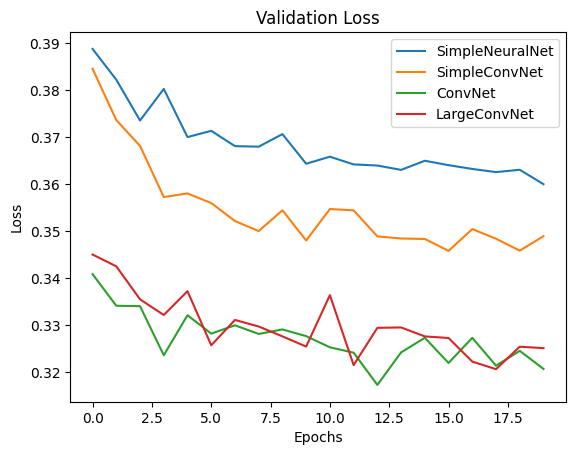

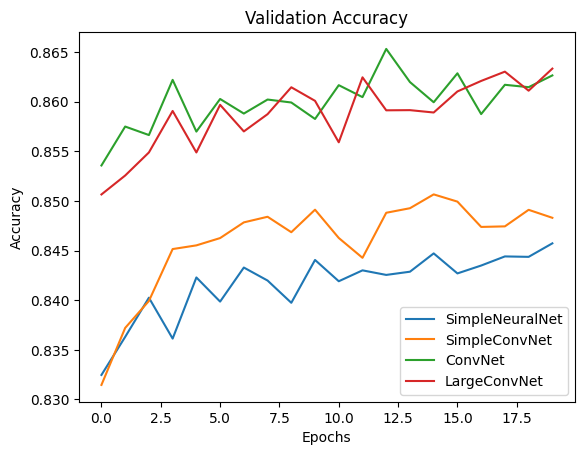

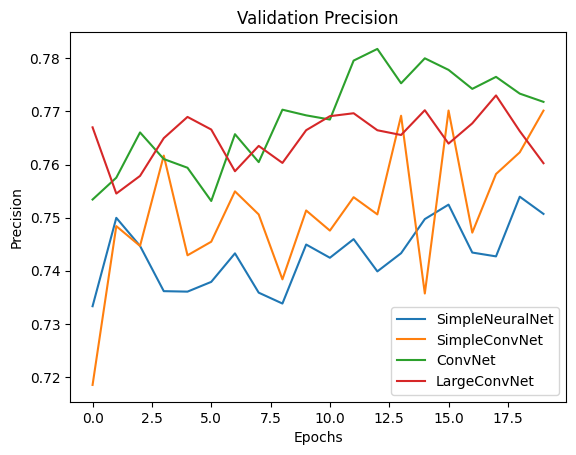

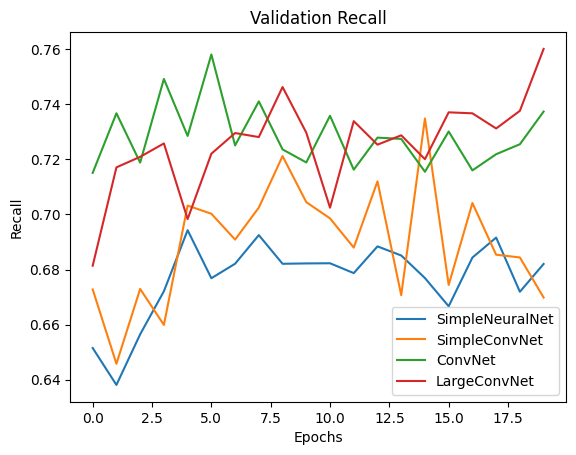

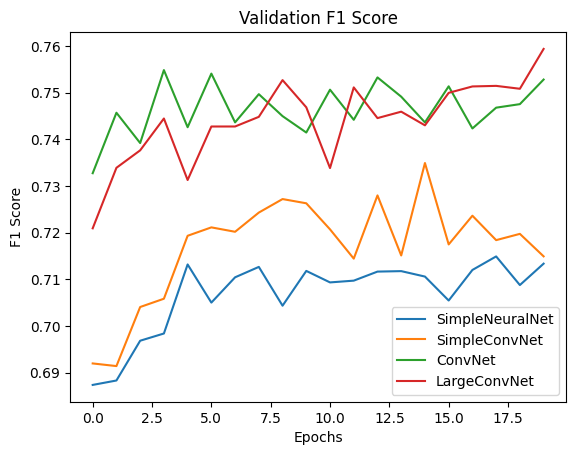

In [6]:
def plot_metrics(metrics, model_names, title, ylabel, xlabel='Epochs'):
    for model_name in model_names:
        mean_metrics = np.mean(metrics[model_name], axis=0)
        plt.plot(mean_metrics, label=model_name)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

model_names = list(models.keys())

plot_metrics(all_val_losses, model_names, title='Validation Loss', ylabel='Loss')
plot_metrics(all_val_accuracies, model_names, title='Validation Accuracy', ylabel='Accuracy')
plot_metrics(all_val_precisions, model_names, title='Validation Precision', ylabel='Precision')
plot_metrics(all_val_recalls, model_names, title='Validation Recall', ylabel='Recall')
plot_metrics(all_val_f1_scores, model_names, title='Validation F1 Score', ylabel='F1 Score')
